In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


class Actions(Enum):
    Sell = 0
    Buy = 1


class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long


class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, df, window_size):
        assert df.ndim == 2

        self.seed()
        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = spaces.Discrete(len(Actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64)

        # episode
        self._start_tick = self.window_size+np.random.randint(len(self.prices)//2)
        self._end_tick = self._start_tick+np.random.randint(len(self.prices)-1-self._start_tick)
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None
        self.shares= None


    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def reset(self):
        self._done = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Short
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 1.  # unit
        self.shares=50
        self.balance=500000#0.5 million
        self._first_rendering = True
        self.history = {}
        return self._get_observation()


    def step(self, action):
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._update_profit(action)

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade:
            self._position = self._position.opposite()
        self._last_trade_tick = self._current_tick





        self._position_history.append(self._position)
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)

        return observation, step_reward, self._done, info


    def _get_observation(self):

        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]


    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)


    def render(self, mode='human'):

        def _plot_position(position, tick):
            color = None
            if position == Positions.Short:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

        plt.pause(0.01)


    def render_all(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        short_ticks = [tick - 1 for tick in short_ticks]
        long_ticks = [tick - 1 for tick in long_ticks]

        plt.plot(long_ticks, self.prices[long_ticks], 'go')
        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )


    def close(self):
        plt.close()


    def save_rendering(self, filepath):
        plt.savefig(filepath)


    def pause_rendering(self):
        plt.show()


    def _process_data(self):
        raise NotImplementedError


    def _calculate_reward(self, action):
        raise NotImplementedError


    def _update_profit(self, action):
        raise NotImplementedError


    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError

In [2]:


class TradingEnv2(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, df, window_size):
        assert df.ndim == 2

        self.seed()
        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = spaces.Discrete(len(Actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64)

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices)-1
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None
        self.shares= None


    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def reset(self):
        self._done = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Short
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 1.  # unit
        self.shares=50
        self.balance=1500000#1 million
        self._first_rendering = True
        self.history = {}
        return self._get_observation()


    def step(self, action):
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._update_profit(action)

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade:
            self._position = self._position.opposite()
        self._last_trade_tick = self._current_tick





        self._position_history.append(self._position)
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)

        return observation, step_reward, self._done, info


    def _get_observation(self):

        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]


    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)


    def render(self, mode='human'):

        def _plot_position(position, tick):
            color = None
            if position == Positions.Short:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

        plt.pause(0.01)


    def render_all(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        short_ticks = [tick - 1 for tick in short_ticks]
        long_ticks = [tick - 1 for tick in long_ticks]

        plt.plot(long_ticks, self.prices[long_ticks], 'go')
        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )


    def close(self):
        plt.close()


    def save_rendering(self, filepath):
        plt.savefig(filepath)


    def pause_rendering(self):
        plt.show()


    def _process_data(self):
        raise NotImplementedError


    def _calculate_reward(self, action):
        raise NotImplementedError


    def _update_profit(self, action):
        raise NotImplementedError


    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
class StocksEnv2(TradingEnv2):

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2

        self.frame_bound = frame_bound
        super().__init__(df, window_size)

        self.trade_fee_bid_percent = 0.0 # unit
        self.trade_fee_ask_percent = 0.0  # unit


    def _process_data(self):
        prices = self.df.loc[:, 'Close'].to_numpy()

        prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
        prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]

        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff))

        return prices, signal_features


    def _calculate_reward(self, action):
        step_reward = 0

        trade=True
        if trade:

            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price
            current_nw= self.balance+self.shares*last_trade_price

            if action==1:
              self.balance-=last_trade_price
              self.shares+=1
              step_reward+=(self.balance+self.shares*current_price)-(current_nw)
            if action==0:
              self.balance+=last_trade_price
              self.shares-=1
              step_reward+=(self.balance+self.shares*current_price)-(current_nw)

        return step_reward


    def _update_profit(self, action):
        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade or self._done:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self._position == Positions.Long:
                shares = (self._total_profit * (1 - self.trade_fee_ask_percent)) / last_trade_price
                self._total_profit = (shares * (1 - self.trade_fee_bid_percent)) * current_price


    def max_possible_profit(self):
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Short
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Long

            if position == Positions.Long:
                current_price = self.prices[current_tick - 1]
                last_trade_price = self.prices[last_trade_tick]
                shares = profit / last_trade_price
                profit = shares * current_price
            last_trade_tick = current_tick - 1

        return profit

In [4]:
class StocksEnv(TradingEnv):

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2

        self.frame_bound = frame_bound
        super().__init__(df, window_size)

        self.trade_fee_bid_percent = 0.0 # unit
        self.trade_fee_ask_percent = 0.0  # unit


    def _process_data(self):
        prices = self.df.loc[:, 'Close'].to_numpy()

        prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
        prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]

        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff))

        return prices, signal_features


    def _calculate_reward(self, action):
        step_reward = 0

        trade=True
        if trade:

            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price
            current_nw= self.balance+self.shares*last_trade_price

            if action==1:
              self.balance-=last_trade_price
              self.shares+=1
              step_reward+=(self.balance+self.shares*current_price)-(current_nw)
            if action==0:
              self.balance+=last_trade_price
              self.shares-=1
              step_reward+=(self.balance+self.shares*current_price)-(current_nw)
            step_reward-=(self.shares<0+self.balance<0)*100
        return step_reward


    def _update_profit(self, action):
        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade or self._done:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self._position == Positions.Long:
                shares = (self._total_profit * (1 - self.trade_fee_ask_percent)) / last_trade_price
                self._total_profit = (shares * (1 - self.trade_fee_bid_percent)) * current_price


    def max_possible_profit(self):
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Short
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Long

            if position == Positions.Long:
                current_price = self.prices[current_tick - 1]
                last_trade_price = self.prices[last_trade_tick]
                shares = profit / last_trade_price
                profit = shares * current_price
            last_trade_tick = current_tick - 1

        return profit

In [5]:
import pandas as pd

# Sample price data (Replace this with your actual price data)
data = {'Close': [100, 105, 110, 102, 95, 85, 90, 80, 85, 95]}
df = pd.DataFrame(data)

window_size = 0
frame_bound = (0, len(df) )

env = StocksEnv(df, window_size, frame_bound)

df


,Close
0,100
1,105
2,110
3,102
4,95
5,85
6,90
7,80
8,85
9,95


In [6]:
env.signal_features.shape[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


10

1
51
499895
-153
0
50
499997
-350
info {'total_reward': -503.0, 'total_profit': 0.9313725490196079, 'position': 0}


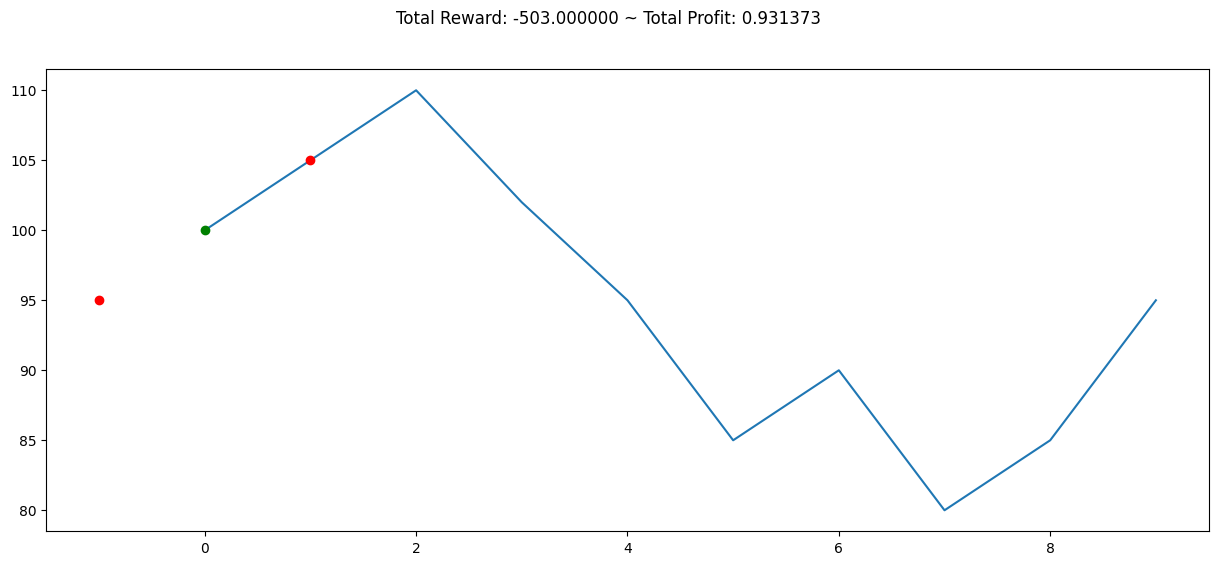

In [7]:
state = env.reset()
while True:
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)

    print(action)
    print(env.shares)
    print(env.balance)
    print(reward)
    if done:
        print("info", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [8]:


stock_data = pd.read_csv('/content/nifty 50 jan2010-jun2019 cleaned.csv')
stock_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,04-01-2010,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0.0
1,05-01-2010,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0.0
2,06-01-2010,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0.0
3,07-01-2010,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0.0
4,08-01-2010,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0.0
...,...,...,...,...,...,...,...
2341,24-06-2019,11725.799810,11754.000000,11670.200200,11699.650390,11699.650390,277600.0
2342,25-06-2019,11681.000000,11814.400390,11651.000000,11796.450200,11796.450200,300500.0
2343,26-06-2019,11768.150390,11871.849610,11757.549810,11847.549810,11847.549810,327900.0
2344,27-06-2019,11860.849610,11911.150390,11821.049810,11841.549810,11841.549810,480200.0


In [9]:

print(stock_data.isnull().sum())
print(len(stock_data))

Date          0
Open         25
High         25
Low          25
Close        25
Adj Close    25
Volume       25
dtype: int64
2346


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
stock_data = stock_data.dropna()

print(stock_data.isnull().sum())
print(len(stock_data))

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
2321


In [11]:
stock_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Open,High,Low,Close,Adj Close,Volume
0,04-01-2010,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0.0
1,05-01-2010,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0.0
2,06-01-2010,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0.0
3,07-01-2010,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0.0
4,08-01-2010,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0.0


In [12]:
stock_data['Date']=pd.to_datetime(stock_data['Date'])
stock_data.dtypes


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-12-deaf6c479787>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  stock_data['Date']=pd.to_datetime(stock_data['Date'])
<ipython-input-12-deaf6c479787>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Date']=pd.to_datetime(stock

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
dtype: object

In [13]:
stock_data.set_index('Date',inplace=True)
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-04-01,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0.0
2010-05-01,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0.0
2010-06-01,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0.0
2010-07-01,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0.0
2010-08-01,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0.0
...,...,...,...,...,...,...
2019-06-24,11725.799810,11754.000000,11670.200200,11699.650390,11699.650390,277600.0
2019-06-25,11681.000000,11814.400390,11651.000000,11796.450200,11796.450200,300500.0
2019-06-26,11768.150390,11871.849610,11757.549810,11847.549810,11847.549810,327900.0


In [14]:
stock_data.drop(columns='Adj Close',inplace=True)
stock_data

<ipython-input-14-f354fc784ee4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data.drop(columns='Adj Close',inplace=True)


,Open,High,Low,Close,Volume
Date,,,,,
2010-04-01,5200.899902,5238.450195,5167.100098,5232.200195,0.0
2010-05-01,5277.149902,5288.350098,5242.399902,5277.899902,0.0
2010-06-01,5278.149902,5310.850098,5260.049805,5281.799805,0.0
2010-07-01,5281.799805,5302.549805,5244.750000,5263.100098,0.0
2010-08-01,5264.250000,5276.750000,5234.700195,5244.750000,0.0
...,...,...,...,...,...
2019-06-24,11725.799810,11754.000000,11670.200200,11699.650390,277600.0
2019-06-25,11681.000000,11814.400390,11651.000000,11796.450200,300500.0
2019-06-26,11768.150390,11871.849610,11757.549810,11847.549810,327900.0


In [15]:
!pip install stable_baselines3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.9 MB/s eta 0:00:00


In [16]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import DQN,A2C,PPO



/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [17]:
env_maker = lambda: StocksEnv(stock_data, 30, (30,len(stock_data)-1))

In [18]:
!pip install shimmy

In [19]:
env = DummyVecEnv([env_maker])

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [20]:
model = DQN('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=5000000)

Streaming output truncated to the last 5000 lines.
|    fps              | 841      |
|    time_elapsed     | 3503     |
|    total_timesteps  | 2948596  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.28e+04 |
|    n_updates        | 724648   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2216     |
|    fps              | 841      |
|    time_elapsed     | 3510     |
|    total_timesteps  | 2953928  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09e+04 |
|    n_updates        | 725981   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2220     |
|    fps              | 841      |
|   

In [21]:
env = StocksEnv2(stock_data, 30, (30,len(stock_data)-1))
obs = env.reset()
b=0
s=0
while True:
    obs = obs[np.newaxis, ...]

    action, _states = model.predict(obs)
    if action==0:
      s+=1
    else:
      b+=1

    obs, rewards, done, info = env.step(action)

    if done:
        print("info", info)
        print(b)
        print(s)
        print(env.balance)
        print(env.shares)

        break

info {'total_reward': 5307183.5985340215, 'total_profit': 0.7247658159360839, 'position': 1}
1766
523
-8261152.805795979
1293


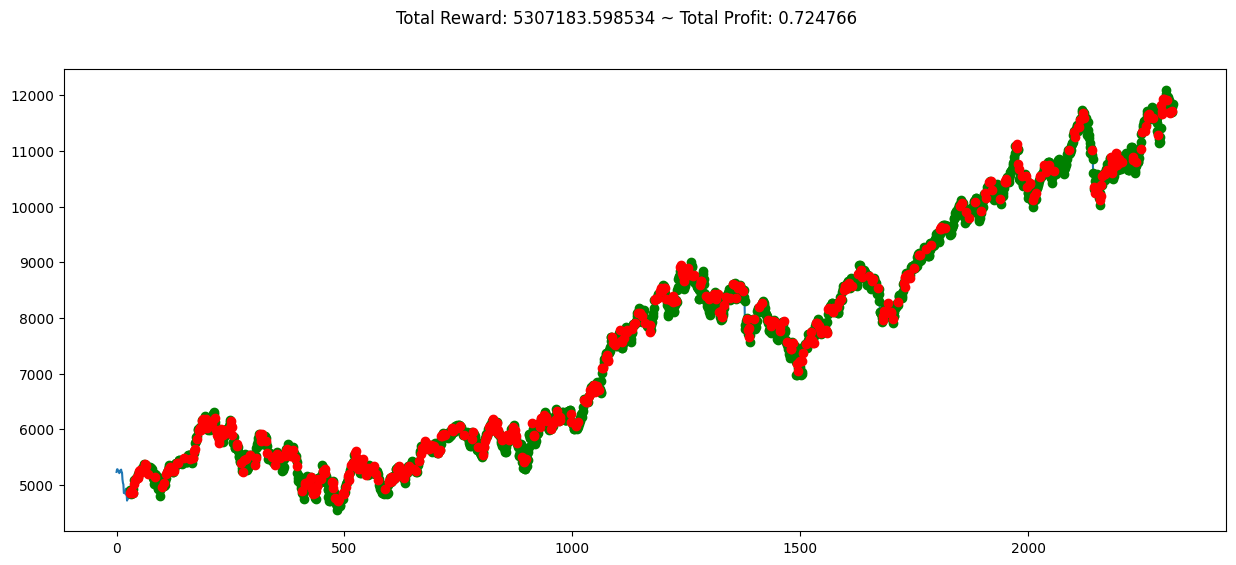

In [22]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

info {'total_reward': 338236.3287880013, 'total_profit': 1.2628780707154852, 'position': 1}
1150
1139
1358689.2903780013
61


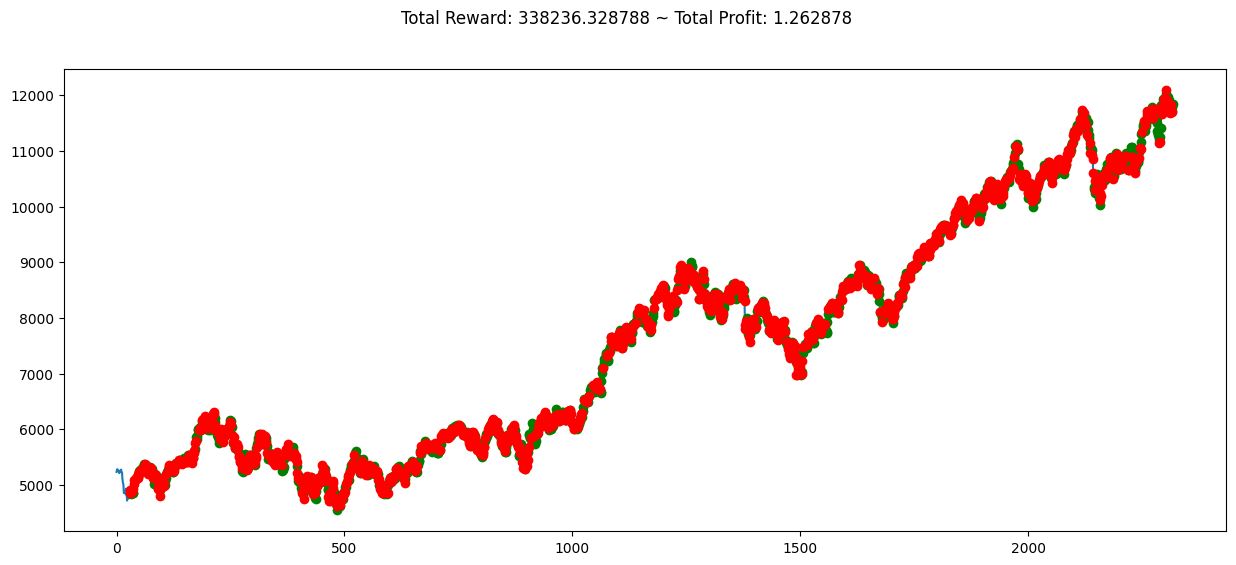

In [23]:
env=StocksEnv2(stock_data,30,(30,len(stock_data)-1))
state = env.reset()
s=0
b=0
while True:
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if action==0:
      s+=1
    else:
      b+=1

    if done:
        print("info", info)
        print(b)
        print(s)
        print(env.balance)
        print(env.shares)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [24]:
test_data = pd.read_csv('/content/nift 50 july2019-jun2021.csv')

In [25]:

test_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-07-01,11839.900391,11884.650391,11830.799805,11865.599609,11865.599609,278400.0
1,2019-07-02,11890.299805,11917.450195,11814.700195,11910.299805,11910.299805,363200.0
2,2019-07-03,11932.150391,11945.200195,11887.049805,11916.750000,11916.750000,340500.0
3,2019-07-04,11928.799805,11969.250000,11923.650391,11946.750000,11946.750000,333600.0
4,2019-07-05,11964.750000,11981.750000,11797.900391,11811.150391,11811.150391,530700.0
...,...,...,...,...,...,...,...
490,2021-06-23,15862.799805,15862.950195,15673.950195,15686.950195,15686.950195,287500.0
491,2021-06-24,15737.299805,15821.400391,15702.700195,15790.450195,15790.450195,316700.0
492,2021-06-25,15839.349609,15870.799805,15772.299805,15860.349609,15860.349609,314600.0
493,2021-06-28,15915.349609,15915.650391,15792.150391,15814.700195,15814.700195,255100.0


In [26]:
print(test_data.isnull().sum())
print(len(test_data))

Date         0
Open         2
High         2
Low          2
Close        2
Adj Close    2
Volume       2
dtype: int64
495


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
test_data = test_data.dropna()

print(test_data.isnull().sum())
print(len(test_data))

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
493


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:

test_data['Date']=pd.to_datetime(test_data['Date'])
test_data.dtypes


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-28-402c4e7eb417>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Date']=pd.to_datetime(test_data['Date'])


Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
dtype: object

In [29]:
test_data.set_index('Date',inplace=True)
test_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-07-01,11839.900391,11884.650391,11830.799805,11865.599609,11865.599609,278400.0
2019-07-02,11890.299805,11917.450195,11814.700195,11910.299805,11910.299805,363200.0
2019-07-03,11932.150391,11945.200195,11887.049805,11916.750000,11916.750000,340500.0
2019-07-04,11928.799805,11969.250000,11923.650391,11946.750000,11946.750000,333600.0
2019-07-05,11964.750000,11981.750000,11797.900391,11811.150391,11811.150391,530700.0
...,...,...,...,...,...,...
2021-06-23,15862.799805,15862.950195,15673.950195,15686.950195,15686.950195,287500.0
2021-06-24,15737.299805,15821.400391,15702.700195,15790.450195,15790.450195,316700.0
2021-06-25,15839.349609,15870.799805,15772.299805,15860.349609,15860.349609,314600.0


In [30]:
test_data.drop(columns='Adj Close',inplace=True)
test_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-30-e173a2c3627a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(columns='Adj Close',inplace=True)


,Open,High,Low,Close,Volume
Date,,,,,
2019-07-01,11839.900391,11884.650391,11830.799805,11865.599609,278400.0
2019-07-02,11890.299805,11917.450195,11814.700195,11910.299805,363200.0
2019-07-03,11932.150391,11945.200195,11887.049805,11916.750000,340500.0
2019-07-04,11928.799805,11969.250000,11923.650391,11946.750000,333600.0
2019-07-05,11964.750000,11981.750000,11797.900391,11811.150391,530700.0
...,...,...,...,...,...
2021-06-23,15862.799805,15862.950195,15673.950195,15686.950195,287500.0
2021-06-24,15737.299805,15821.400391,15702.700195,15790.450195,316700.0
2021-06-25,15839.349609,15870.799805,15772.299805,15860.349609,314600.0


In [31]:
env = StocksEnv2(test_data, 30, (30,len(test_data)-1))
obs = env.reset()
while True:
    obs = obs[np.newaxis, ...]

    action, _states = model.predict(obs)

    obs, rewards, done, info = env.step(action)


    if done:
        print(env.balance)
        print(env.shares)
        print("info", info)
        break

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-633991.4003999998
225
info {'total_reward': 868833.6239250004, 'total_profit': 1.223408999103722, 'position': 1}


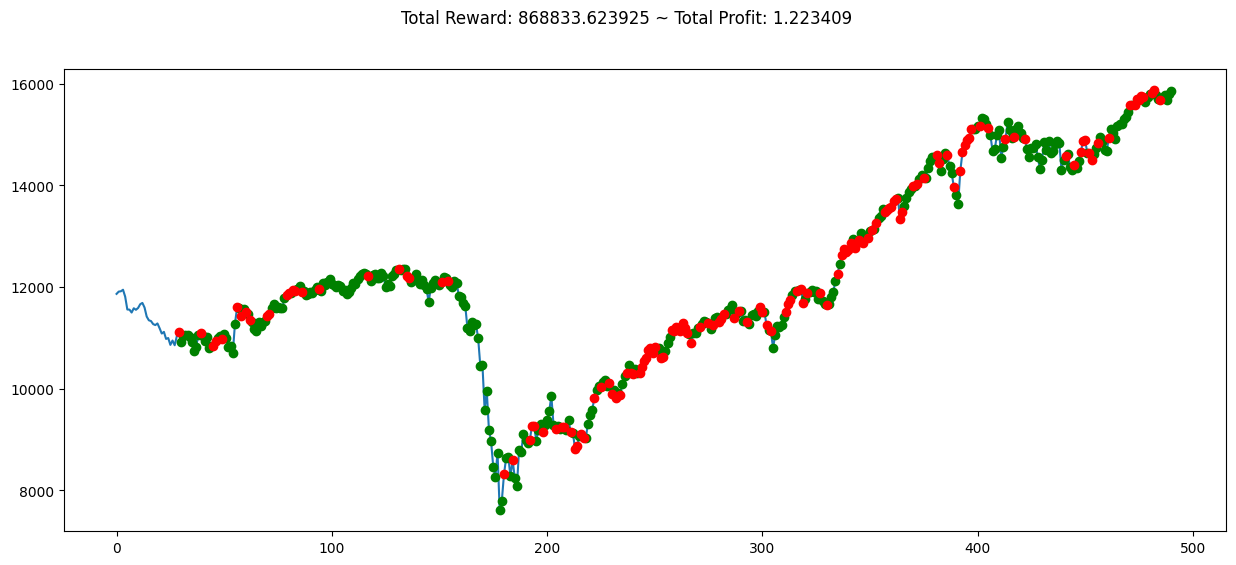

In [32]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

info {'total_reward': 175756.3779009981, 'total_profit': 1.4396922747184304, 'position': 1}
222
239


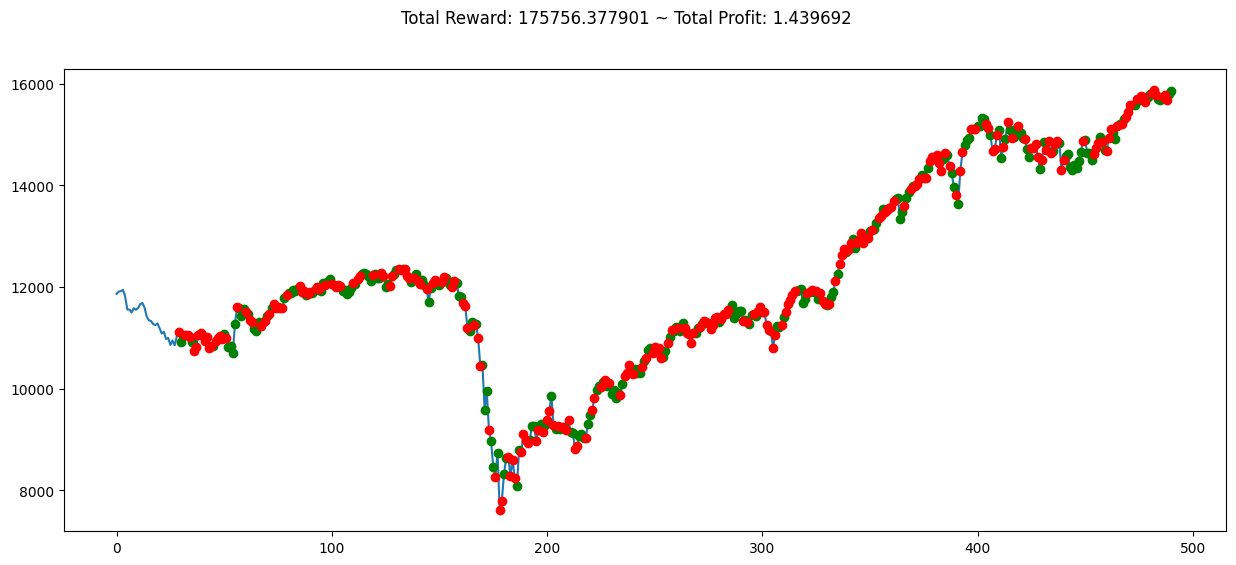

In [33]:
env=StocksEnv2(test_data,30,(30,len(test_data)-1))
state = env.reset()
s=0
b=0
while True:
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if action==0:
      s+=1
    else:
      b+=1

    if done:
        print("info", info)
        print(b)
        print(s)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [34]:
model.save('dqn_model')

In [35]:
from google.colab import files

In [36]:
files.download('dqn_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
pre=model.load('/content/dqn_model.zip')

In [44]:
env = StocksEnv2(test_data, 30, (30,len(test_data)-1))
obs = env.reset()
while True:
    obs = obs[np.newaxis, ...]

    action, _states = pre.predict(obs)

    obs, rewards, done, info = env.step(action)


    if done:
        print(env.balance)
        print(env.shares)
        print("info", info)
        break

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1059294.6035119998
17
info {'total_reward': 272661.987277, 'total_profit': 1.1669555182127875, 'position': 1}


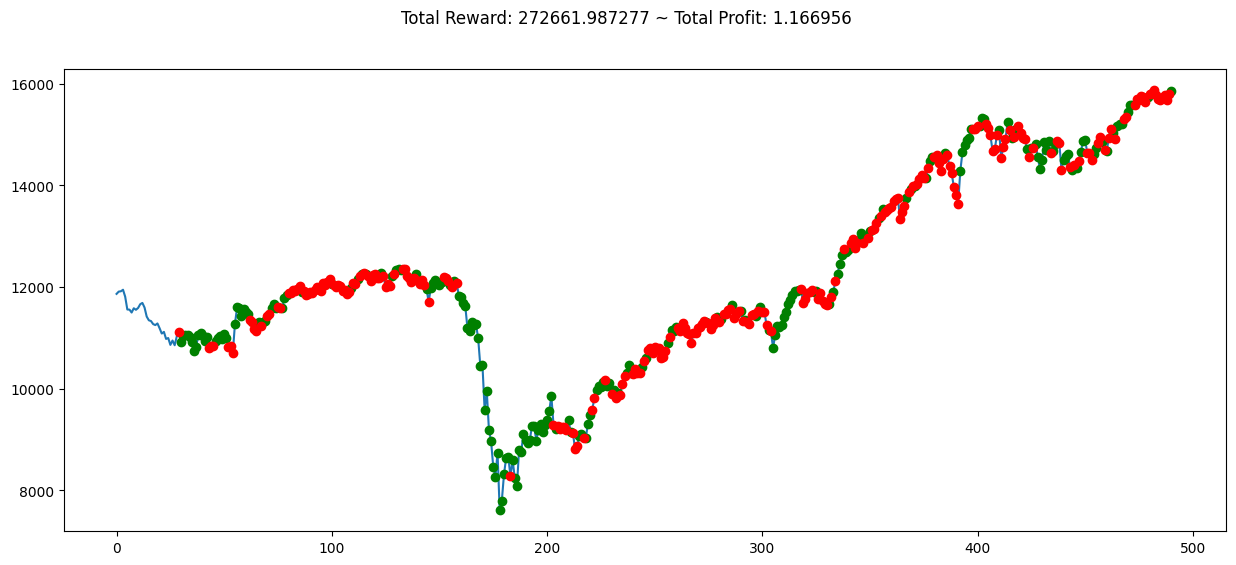

In [45]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()